In [1]:
import json, pickle
from collections import Counter
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from scipy.sparse import vstack, hstack
from scipy.stats.stats import spearmanr
from scipy.stats.stats import kendalltau
from tqdm import tqdm

warnings.filterwarnings("ignore")

Прочитаем, проанализируем и преобразуем в более удобный вид данные, а также отберем только те турниры, где есть данные о командах и их повопросных результатах, так как очень много турниров без информации о результатах

In [2]:
tournaments = pickle.load(open('chgk/tournaments.pkl', 'rb'))
results = pickle.load(open('chgk/results.pkl', 'rb'))
players = pickle.load(open('chgk/players.pkl', 'rb'))

In [3]:
data_players = pd.DataFrame(players.values()).set_index("id")
data_tournaments = pd.DataFrame(tournaments.values()).set_index("id")

data_tournaments["year"] = data_tournaments["dateStart"].apply(lambda x: int(x[:4]))
data_train_tournaments = data_tournaments[data_tournaments["year"] == 2019]
data_test_tournaments = data_tournaments[data_tournaments["year"] == 2020]


In [4]:
data_tournaments

,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty,year
id,,,,,,,,,
1,Чемпионат Южного Кавказа,2003-07-25T00:00:00+04:00,2003-07-27T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None,2003
2,Летние зори,2003-08-09T00:00:00+04:00,2003-08-09T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None,2003
3,Турнир в Ижевске,2003-11-22T00:00:00+03:00,2003-11-24T00:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None,2003
4,Чемпионат Украины. Переходной этап,2003-10-11T00:00:00+04:00,2003-10-12T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None,2003
5,Бостонское чаепитие,2003-10-10T00:00:00+04:00,2003-10-13T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None,2003
...,...,...,...,...,...,...,...,...,...
6481,Онлайн: 15:00 (а)Синхрон-lite. Лига старта. Эп...,2020-05-05T15:00:00+03:00,2020-05-05T18:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/53,"[{'id': 7533, 'name': 'Денис', 'patronymic': '...",None,"{'1': 12, '2': 12, '3': 12}",2020
6482,Онлайн: 19:00 Зелёный шум,2020-05-07T19:00:00+03:00,2020-05-07T21:30:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/53,"[{'id': 7533, 'name': 'Денис', 'patronymic': '...",None,"{'1': 13, '2': 13, '3': 13}",2020
6483,Онлайн: 19:00 (а)Синхрон-lite. Лига старта. Эп...,2020-05-08T19:00:00+03:00,2020-05-08T21:30:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/53,"[{'id': 7533, 'name': 'Денис', 'patronymic': '...",None,"{'1': 12, '2': 12, '3': 12}",2020


In [5]:
data_players

,name,patronymic,surname
id,,,
1,Алексей,None,Абабилов
10,Игорь,,Абалов
11,Наталья,Юрьевна,Абалымова
12,Артур,Евгеньевич,Абальян
13,Эрик,Евгеньевич,Абальян
...,...,...,...
224700,Артём,Евгеньевич,Садов
224701,Даниил,Олегович,Трефилов
224702,Владимир,Араратович,Басенцян


In [6]:
train_info = []
all_players_index = set()
all_questions_index = []

In [7]:
for index in data_train_tournaments.index:
    tournament_results = results[index]
    cnt_questions = set()
    
    mask = ""
    
    for team in results[index]:
        if team.get('mask') is not None:
            cnt_questions.add(len(team['mask'].replace("?", "").replace("X", "")))

    if len(cnt_questions) >  1:
        continue
    for team in tournament_results:
        info = {}
        if team.get("mask") is None or team.get("teamMembers") is None:
            continue
        if team["teamMembers"] == []:
            continue
        
        mask = team["mask"].replace("?", "").replace("X", "")
        info["tournament_id"] = index
        info["team_id"] = team.get("team").get("id")
        info["mask"] = list(map(int, mask))
        info["players_id"] = []
        players = team["teamMembers"]
        
        for player in players:
            info["players_id"].append(player["player"]["id"])
            all_players_index.add(player["player"]["id"])
    
        train_info.append(info)
    
    if mask:
        for i, _ in enumerate(mask):
            all_questions_index.append(str(index) + "-" + str(i))

all_players_index = list(all_players_index)

Преобразовали данные в вид, где есть информация о номере турнира, номере команды в этом турнире, списке игроков команды и повопросные результаты команды

In [8]:
train_info[0]

{'tournament_id': 4772,
 'team_id': 45556,
 'mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0],
 'players_id': [6212, 18332, 18036, 22799, 15456, 26089]}

In [9]:
all_players_index

[131077,
 131080,
 131082,
 131083,
 15,
 16,
 23,
 131098,
 131099,
 31,
 131106,
 35,
 131108,
 38,
 131111,
 131112,
 131117,
 47,
 131120,
 208423,
 208424,
 59,
 131135,
 208425,
 65,
 131139,
 131140,
 131146,
 131147,
 79,
 80,
 82,
 131154,
 131157,
 131159,
 98,
 131176,
 131177,
 131179,
 131180,
 112,
 113,
 117,
 131190,
 119,
 133,
 136,
 144,
 131221,
 131222,
 150,
 131223,
 153,
 208443,
 131224,
 131229,
 131230,
 131231,
 160,
 157,
 131235,
 131240,
 176,
 178,
 182,
 131263,
 131267,
 196,
 131270,
 131271,
 131277,
 131282,
 131283,
 131285,
 131290,
 131291,
 131292,
 223,
 131301,
 230,
 131303,
 232,
 233,
 236,
 131313,
 131315,
 131320,
 131322,
 131333,
 261,
 263,
 208466,
 131347,
 278,
 131353,
 286,
 131373,
 131377,
 131384,
 131387,
 315,
 131389,
 131394,
 323,
 322,
 328,
 330,
 131406,
 131410,
 131415,
 131416,
 131417,
 131418,
 131419,
 131420,
 345,
 131422,
 131423,
 131426,
 354,
 131443,
 131445,
 131446,
 376,
 377,
 379,
 131451,
 131453,
 1

In [10]:
all_questions_index[:10]

['4772-0',
 '4772-1',
 '4772-2',
 '4772-3',
 '4772-4',
 '4772-5',
 '4772-6',
 '4772-7',
 '4772-8',
 '4772-9']

Попрпобуем сначал построить бейзлайн при помощи логистической регрессии, где мы будем обучать силу игрока, а также сложность каждого вопроса. Для обучения будем использовать при помощи OneHotEncoder вектора с длиной количество игроков + количество вопросов, где первый вектор отвечает за то, какой игрок отвечает, а второй отвечает за то, на какой вопрос он отвечает. Также мы пока не учитываем в какой команде был игрок, а только учитываем правильно ли он(вместе с командой) на него ответил. То есть решаем задачу бинарной классификации. На выходе мы получим веса для каждого игрока, которые показывают силу игрока, а также веса для вопросов, которые показывают их сложность. 

In [11]:
ohe_hot_players = OneHotEncoder()
ohe_hot_questions = OneHotEncoder()

all_players_index = np.array(all_players_index)
all_players_index = all_players_index.reshape(-1, 1)
ohe_all_players_index = ohe_hot_players.fit_transform(all_players_index)

all_questions_index = np.array(all_questions_index)
all_questions_index = all_questions_index.reshape(-1, 1)
ohe_all_questions_index = ohe_hot_questions.fit_transform(all_questions_index)

In [30]:
arr_players.shape

(216, 1)

In [31]:
tour_questions

['6191-0',
 '6191-1',
 '6191-2',
 '6191-3',
 '6191-4',
 '6191-5',
 '6191-6',
 '6191-7',
 '6191-8',
 '6191-9',
 '6191-10',
 '6191-11',
 '6191-12',
 '6191-13',
 '6191-14',
 '6191-15',
 '6191-16',
 '6191-17',
 '6191-18',
 '6191-19',
 '6191-20',
 '6191-21',
 '6191-22',
 '6191-23',
 '6191-24',
 '6191-25',
 '6191-26',
 '6191-27',
 '6191-28',
 '6191-29',
 '6191-30',
 '6191-31',
 '6191-32',
 '6191-33',
 '6191-34',
 '6191-35']

In [32]:
quest_hot.todense().shape

(216, 30039)

In [12]:
data_for_train = []
data_for_answer = []

for team in tqdm(train_info):
    tour_id = team['tournament_id']
    team_id = team['team_id']
    mask = team['mask']
    pl_id = team['players_id']
    
    tour_questions = []
    
    arr_players = []
    for pl in pl_id:
        arr_players.extend(len(mask) * [pl])
    
    arr_players = np.array(arr_players)
    arr_players = arr_players.reshape(-1, 1)
    
    players_hot = ohe_hot_players.transform(arr_players)
    
    for i in range(len(mask)):
        tour_questions.append(str(tour_id) + '-' + str(i))
        
    arr_quest = tour_questions * len(pl_id)
    arr_quest = np.array(arr_quest).reshape(-1, 1)
    quest_hot = ohe_hot_questions.transform(arr_quest)
    
    data_for_answer.append(np.array(mask * len(pl_id)).reshape(-1, 1))
    matr_to_train = np.hstack([players_hot, quest_hot])
    data_for_train.append(matr_to_train)


100%|██████████| 76490/76490 [02:54<00:00, 437.46it/s]


In [13]:
for i in tqdm(range(len(data_for_train))):
    data_for_train[i] = hstack([data_for_train[i][0], data_for_train[i][1]])
    

100%|██████████| 76490/76490 [00:30<00:00, 2514.48it/s]


In [37]:
1.7777777 * 1080

1919.999916

In [38]:
1920 / 1080, 16/9

(1.7777777777777777, 1.7777777777777777)

In [39]:
data = vstack(data_for_train)

In [40]:
data

<15727008x86386 sparse matrix of type '<class 'numpy.float64'>'
	with 31454016 stored elements in COOrdinate format>

In [41]:
target = np.vstack(data_for_answer)

In [49]:
pd.Series(target.flatten()).value_counts()

0    8941132
1    6785876
dtype: int64

In [42]:
clf = LogisticRegression(solver='saga')
clf.fit(data, target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
clf.coef_

array([[ 0.75611998,  1.5974937 ,  1.13448847, ..., -0.50203864,
         5.05130511,  3.06910476]])

In [44]:
ohe_hot_players.get_feature_names()

array(['x0_15', 'x0_16', 'x0_23', ..., 'x0_224408', 'x0_224482',
       'x0_224539'], dtype=object)

In [45]:
players_index_in_train = set()
for team in train_info:
    for pl_id in team["players_id"]:
        players_index_in_train.add(pl_id)

players_index_in_train = list(players_index_in_train)
players_index_in_train.sort()

rate_of_player = pd.DataFrame({'players_id': players_index_in_train,
                       'strength': clf.coef_[0][:len(players_index_in_train)]})

In [51]:
rate_of_player.tail(70)

,players_id,strength
56277,219246,0.892178
56278,219309,-0.636504
56279,219310,-1.723917
56280,219356,1.955515
56281,219357,1.955513
...,...,...
56342,224403,-2.199347
56343,224404,-0.855000
56344,224408,-0.167442
56345,224482,-0.522061


In [52]:
count_quest_of_every_player = {}


for team in train_info:
    for pl_id in team["players_id"]:
        if pl_id in count_quest_of_every_player:
            count_quest_of_every_player[pl_id] += len(mask)
        else:
            count_quest_of_every_player[pl_id] = 0

In [53]:
df_count_quest = pd.DataFrame.from_dict(count_quest_of_every_player, orient='index')

In [60]:
df_count_quest

,0,players_id
6212,2700,6212
18332,3132,18332
18036,1080,18036
22799,1656,22799
15456,1620,15456
...,...,...
217855,0,217855
217856,0,217856
217857,0,217857
217858,0,217858


In [59]:
df_count_quest["players_id"] = df_count_quest.index

In [57]:
player_copy = data_players.copy()
player_copy["players_id"] = player_copy.index

rate_of_player = player_copy.merge(rate_of_player, on="players_id")

In [61]:
rate_of_player

,name,patronymic,surname,players_id,strength
0,Олег,Игоревич,Абарников,15,0.756120
1,Азер,Абасали оглы,Абасалиев,16,1.597494
2,Андрей,Николаевич,Абащенко,23,1.134488
3,Ситара,Фахраддин гызы,Абасова,31,1.132534
4,Нарек,Гагикович,Абгарян,35,1.112606
...,...,...,...,...,...
56342,Анастасия,Евгеньевна,Кузнецова,224403,-2.199347
56343,Виктория,Максимовна,Кузнецова,224404,-0.855000
56344,Виктор,,Андреев,224408,-0.167442
56345,Юлия,,Тур,224482,-0.522061


In [62]:
rate_of_player = rate_of_player.merge(df_count_quest, on="players_id")

In [63]:
rate_of_player.rename(columns = {0:'count'}, inplace = True)

In [64]:
rate_of_player

,name,patronymic,surname,players_id,strength,count
0,Олег,Игоревич,Абарников,15,0.756120,432
1,Азер,Абасали оглы,Абасалиев,16,1.597494,72
2,Андрей,Николаевич,Абащенко,23,1.134488,0
3,Ситара,Фахраддин гызы,Абасова,31,1.132534,684
4,Нарек,Гагикович,Абгарян,35,1.112606,648
...,...,...,...,...,...,...
56342,Анастасия,Евгеньевна,Кузнецова,224403,-2.199347,0
56343,Виктория,Максимовна,Кузнецова,224404,-0.855000,36
56344,Виктор,,Андреев,224408,-0.167442,0
56345,Юлия,,Тур,224482,-0.522061,0


Выведем топ 50 игроков, а также, чтобы исключить игроков, которые сыграли мало игр, поставим условие количество отвеченных вопросов больше 1200:

In [173]:
rate_of_player[rate_of_player['count'] > 1200].sort_values(by='strength', ascending=False).head(50)

,name,patronymic,surname,players_id,strength,count
3832,Максим,Михайлович,Руссо,27403,4.164991,1872
601,Александра,Владимировна,Брутер,4270,4.033636,2304
4021,Иван,Николаевич,Семушин,28751,3.984045,3276
3904,Михаил,Владимирович,Савченков,27822,3.895236,2664
4207,Артём,Сергеевич,Сорожкин,30152,3.815803,4320
4227,Сергей,Леонидович,Спешков,30270,3.815690,2952
2908,Станислав,Григорьевич,Мереминский,20691,3.691010,1260
3202,Сергей,Игоревич,Николенко,22799,3.564367,1656
2594,Александр,Витальевич,Либер,18332,3.521475,3132
2803,Александр,Валерьевич,Марков,19915,3.494593,2412


In [ ]:
Видим, что в топе находятся те же люди, что и в реальном рейтинге

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах. Поэтому нужно предсказать результаты нового турнира с известными составами, но неизвестными вопросами в виде ранжирования команд. В качестве метрики качества на тестовом наборе будем считать ранговые корреляции Спирмена и Кендалла между реальным результатом ранжирования турнира и предсказанным

Попробуем такую идею: посмотрим как распределены вопросы и выберем средний по сложности. На этот вопрос и будет отвечать команды из тестового множества.

In [180]:
rate_of_player.strength

0        0.756110
1        1.597481
2        1.134480
3        1.132524
4        1.112600
           ...   
56342   -2.199350
56343   -0.855006
56344   -0.167448
56345   -0.522065
56346    0.848935
Name: strength, Length: 56347, dtype: float64

<AxesSubplot:xlabel='Распределение скилла игроков', ylabel='Density'>

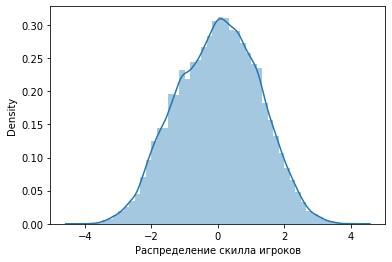

In [192]:
sns.distplot(rate_of_player.strength, axlabel = "Распределение скилла игроков")

<AxesSubplot:xlabel='Распределение сложности вопросов', ylabel='Density'>

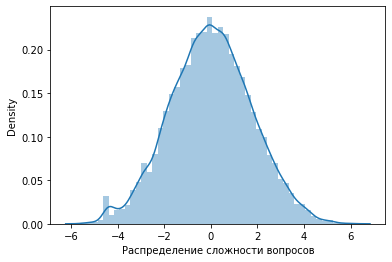

In [193]:
sns.distplot(clf.coef_[0][len(players_index_in_train):], axlabel = "Распределение сложности вопросов")

Видим, что распределение вопросов симметричное, поэтому за среднйи по сложности вопрос можно взять минимальный по модулю, скорее всего он будет очень близок к нулю 

In [234]:
mid_quest = np.abs(clf.coef_[0][len(all_pl):]).min()
mid_quest_ind = 0

for i in range(clf.coef_[0][len(all_pl):].shape[0]):
    if abs(clf.coef_[0][len(all_pl):][i]) == mid_quest:
        mid_quest_ind = i
        
mid_quest = ohe_hot_questions.categories_[0][mid_quest_ind]


In [235]:
mid_quest

'5649-62'

Предобработаем тестовые данные, по сранению с данными для обучения в них есть данные о позиции команды в турнире

In [238]:
test_info = []

for index in data_test_tournaments.index:
    tournament_results = results[index]
    cnt_questions = set()
    
    mask = ""
    
    data_tournament_results = []
    
    for team in results[index]:
        if team.get('mask') is not None:
            cnt_questions.add(len(team['mask'].replace("?", "").replace("X", "")))

    if len(cnt_questions) > 1:
        continue
        
    for team in tournament_results:
        info = {}
        if team.get("mask") is None or team.get("teamMembers") is None:
            continue
        if team["teamMembers"] == []:
            continue
        
        mask = team["mask"].replace("?", "").replace("X", "")
        info["tournament_id"] = index
        info["team_id"] = team.get("team").get("id")
        info["mask"] = list(map(int, mask))
        info["players_id"] = []
        info["position"] = team["position"]
        players = team["teamMembers"]
        
        for player in players:
            info["players_id"].append(player["player"]["id"])
        
        data_tournament_results.append(info)
    if mask:
        test_info.append(data_tournament_results)

In [241]:
test_info[0][0]

{'tournament_id': 4957,
 'team_id': 49804,
 'mask': [1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1],
 'players_id': [30152, 30270, 27822, 28751, 27403, 4270],
 'position': 1}

Будем использовать обученную модель логистической регрессии и предскажем вероятность правильного ответа для каждого игрока команды на этот средний вопрос, после чего рейтингом команды будет усредненная вероятность правильного ответа на средний вопрос каждого игрока команды

In [252]:
result_of_test = {}

for tour in tqdm(test_info):
    tour_res = {}
    
    for team in tour:
        team_players = []
        for pl in team["players_id"]:
            try:
                ohe_hot_players.transform([[pl]])
                team_players.append(pl)
            except ValueError:
                continue   
        if len(team_players) == 0:
            continue
        
        team_players = np.array(team_players).reshape(-1, 1)
        matrix_of_pl = ohe_hot_players.transform(team_players)
        matrix_of_qu = ohe_hot_questions.transform(np.array([mid_quest] * len(team_players)).reshape(-1, 1))
        
        val = hstack([matrix_of_pl, matrix_of_qu])
        res = clf.predict_proba(val)[:, 1]
        
        skill = res.mean()
        tour_res[team["team_id"]] = (skill, team["position"])
    
    result_of_test[tour[0]["tournament_id"]] = tour_res

100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [13:48<00:00,  5.02s/it]


In [262]:
spearman_res = []
kendall_res = []

for tour in result_of_test.values():
    pred = []
    real_res = []
    for team in tour.values():
        pred.append(team[0])
        real_res.append(team[1])
        
    spearman_res.append(spearmanr(pred, real_res)[0])
    kendall_res.append(kendalltau(pred, real_res)[0])

spear = np.mean([x for x in spearman_res if np.isfinite(x)])
kendall = np.mean([y for y in kendall_res if np.isfinite(y)])


print('Spearman: {}'.format(abs(spear)))
print('Kendall: {}'.format(abs(kendall)))

Spearman: 0.781233527013567
Kendall: 0.6259876339517997


Используем теперь другую формулу для подсчета скилла команды. Вероятность правильного ответа команды на средний вопрос считается по формуле: $Skillteam = 1 - \prod_{i \in team} (1 - P [skill_i, MidQuest])$, team - список игроков в команде.

In [263]:
result_of_test = {}

for tour in tqdm(test_info):
    tour_res = {}
    
    for team in tour:
        team_players = []
        for pl in team["players_id"]:
            try:
                ohe_hot_players.transform([[pl]])
                team_players.append(pl)
            except ValueError:
                continue   
        if len(team_players) == 0:
            continue
        
        team_players = np.array(team_players).reshape(-1, 1)
        matrix_of_pl = ohe_hot_players.transform(team_players)
        matrix_of_qu = ohe_hot_questions.transform(np.array([mid_quest] * len(team_players)).reshape(-1, 1))
        
        val = hstack([matrix_of_pl, matrix_of_qu])
        res = clf.predict_proba(val)[:, 1]
        skill = 1 - np.product(1 - res)
        
        tour_res[team["team_id"]] = (skill, team["position"])
    
    result_of_test[tour[0]["tournament_id"]] = tour_res

100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [13:48<00:00,  5.02s/it]


In [264]:
spearman_res = []
kendall_res = []

for tour in result_of_test.values():
    pred = []
    real_res = []
    for team in tour.values():
        pred.append(team[0])
        real_res.append(team[1])
        
    spearman_res.append(spearmanr(pred, real_res)[0])
    kendall_res.append(kendalltau(pred, real_res)[0])

spear = np.mean([x for x in spearman_res if np.isfinite(x)])
kendall = np.mean([y for y in kendall_res if np.isfinite(y)])


print('Spearman: {}'.format(abs(spear)))
print('Kendall: {}'.format(abs(kendall)))

Spearman: 0.8062814902134353
Kendall: 0.6484069509339149


Видим, что метрики улучшились

Но всё-таки ЧГК это командная игра, а мы до этого никак это не учитывали и брали, что конкретный игрок отвечает на вопрос. Нужно учитывать, что на один вопрос отвечают сразу несколько игроков, то есть теперь получается игрок X ответил на вопрос Y должны стать зависимыми для игроков из одной команды. Разработаем EM-схему для решения этой задачи.

Возьмём за скрытые переменные $z_i{}_j$
* E-шаг: находим мат. ожидания $z_i{}_j$ (мат. ожидание того, что игрок i правильно ответил на вопрос j). 

1) $E[z_i{}_j] = 0$, если вся команда не ответила на вопрос $j$.

2) $E[z_i{}_j] = \frac{P [skill_i, question_j]}{1 - \prod_{n \in team} (1 - P [skill_n, question_j])}$, если комада ответила на вопрос $j$. 

Формулу из п.2 получаем по теореме Байеса: 

Пусть событие A - это команда правильно ответила на вопрос. А событие B - это игрок из команды правильно ответил на вопрос.

$P(B|A) = \frac{P(A|B)P(B)}{P(A)}$; $P(A|B) = 1$ (если игрок ответил на вопрос, то и комада ответила на вопрос). Тогда: $P(B|A) = \frac{P(B)}{P(A)}$

* M-шаг: пересчитываем параметры логистической регрессии, используя новые $z_i{}_j$.

In [265]:
def calc_score(model):
    result_of_test = {}

    for tour in tqdm(test_info):
        tour_res = {}

        for team in tour:
            team_players = []
            for pl in team["players_id"]:
                try:
                    ohe_hot_players.transform([[pl]])
                    team_players.append(pl)
                except ValueError:
                    continue   
            if len(team_players) == 0:
                continue

            team_players = np.array(team_players).reshape(-1, 1)
            matrix_of_pl = ohe_hot_players.transform(team_players)
            matrix_of_qu = ohe_hot_questions.transform(np.array([mid_quest] * len(team_players)).reshape(-1, 1))

            val = hstack([matrix_of_pl, matrix_of_qu])
            res = model.predict_proba(val)[:, 1]
            skill = 1 - np.product(1 - res)

            tour_res[team["team_id"]] = (skill, team["position"])

        result_of_test[tour[0]["tournament_id"]] = tour_res
    
    
    spearman_res = []
    kendall_res = []

    for tour in result_of_test.values():
        pred = []
        real_res = []
        for team in tour.values():
            pred.append(team[0])
            real_res.append(team[1])

        spearman_res.append(spearmanr(pred, real_res)[0])
        kendall_res.append(kendalltau(pred, real_res)[0])

    spear = np.mean([x for x in spearman_res if np.isfinite(x)])
    kendall = np.mean([y for y in kendall_res if np.isfinite(y)])
    
    
    return abs(spear), abs(kendall)

In [269]:
def E_step(model, data, target):

    pred = model.predict_proba(data)[:, 1]
    start = 0
    for team in tqdm(train_info):
        team_size = len(team["players_id"])
        mask_size = len(team["mask"])
        beg = start
        end = start + len(team["players_id"]) * len(team["mask"])
        
        team_preds = pred[beg: end]
        
        team_ans = pred[beg: end]
        
        true_ans = target[beg: start + len(team["mask"])]
        team_ans = team_ans.reshape((-1, mask_size)).T
        
        p_A = 1 - np.prod(1 - team_ans, axis=1)
        team_ans = team_ans / p_A.reshape(-1, 1)
        
        team_ans = np.where(true_ans != 0, team_ans, 0)
        
        pred[beg: end] = team_ans.T.reshape(-1) 
        start += len(team["players_id"]) * len(team["mask"])   
    return pred

In [272]:
def M_step(z_ij, data):
    z_ij = np.array(z_ij)
    
    y_0 = np.full((data.shape[0], 1), 0)
    y_1 = np.full((data.shape[0], 1), 1)
    targets = np.vstack((y_0, y_1))
    
    x = vstack([data, data])
    weights = np.hstack((1 - z_ij, z_ij))
    model = LogisticRegression(solver="saga")
    model.fit(x, targets, sample_weight=weights)
    
    return model

In [275]:
cnt = 5

models = []
model = clf
for i in range(cnt):
    z_ij = E_step(model, data, target)
    model = M_step(z_ij, data)
    models.append(model)
    
    spear, kendall = calc_score(model)
    
    print('Spearman: {}'.format(abs(spear)))
    print('Kendall: {}'.format(abs(kendall)))

100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [13:45<00:00,  5.01s/it]


Spearman: 0.8132020485388202
Kendall: 0.6552262920560997


100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [14:27<00:00,  5.26s/it]


Spearman: 0.813196736070927
Kendall: 0.6551455779130075


100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [14:43<00:00,  5.35s/it]


Spearman: 0.8123022530359993
Kendall: 0.6547763563916134


100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [13:33<00:00,  4.93s/it]


Spearman: 0.8118773646314291
Kendall: 0.6551912676786392


100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [13:50<00:00,  5.03s/it]

Spearman: 0.8116376271285599
Kendall: 0.6548762542340728
